In [2]:
# Import packages, the Y-matrix for the dataset and Functions.py
import numpy as np
%run Dolphins_data_import.ipynb
import sys
sys.path.append('../')
from Functions import * 
import copy
import random
%store -r points
%store -r random_numbers_matrix

In [208]:
dim = 2

# Define mu and cov_matrix to be able to sample #num_samples samples from a multivariate normal distribution
mu = np.zeros(dim) 
identity_matrix = np.eye(dim) 
cov_matrix = identity_matrix 

points = {l+1: np.random.multivariate_normal(mu, cov_matrix) for l in range(num_dolphins)}
num_samples = num_dolphins

In [209]:
alpha = 2

In [221]:
True_posetiv = np.zeros(len(random_numbers_matrix))
True_negativ = np.zeros(len(random_numbers_matrix))
False_posetiv = np.zeros(len(random_numbers_matrix))
False_negativ = np.zeros(len(random_numbers_matrix))

True_posetiv_baseline = np.zeros(len(random_numbers_matrix))
True_negativ_baseline = np.zeros(len(random_numbers_matrix))
False_posetiv_baseline = np.zeros(len(random_numbers_matrix))
False_negativ_baseline = np.zeros(len(random_numbers_matrix))

Accuracy = np.zeros(len(random_numbers_matrix))
Accuracy_baseline = np.zeros(len(random_numbers_matrix))

MLL_final = np.zeros(len(random_numbers_matrix)) # Define the MLL
grad_sum_final = np.zeros(len(random_numbers_matrix)) # Define the gradient sum

for s in range(len(random_numbers_matrix)):
    Y_updated = np.delete(Y,random_numbers_matrix[s].flatten().astype(int), axis=0)

    prev_grad = 200
    grad = 0
    n = 100000
    points_copy = copy.deepcopy(points)
    MLL = np.zeros(n) # Define the MLL
    grad_sum = np.zeros(n) # Define the gradient sum
    k = 0

    while abs(prev_grad - grad) > 0.001: # stopping criteria
        prev_grad = grad
        for i in range(1,num_samples+1): # Run over number of num_samples
            grad_now = Gradient_function_prior_fast(i,dim,Y_updated,points_copy,alpha)
            grad_sum[k] += np.sum((grad_now)**2)
            points_copy[i] += LR(k)*grad_now # Use Gradient_function and take step=0.1*grad
        grad = grad_sum[k]
        MLL[k] = Loss_function_prior_fast(points_copy,Y_updated,dim,alpha) # Calcualte the probability using Loss_function
        k += 1

    MLL_final[s] = MLL[k-1]
    grad_sum_final[s] = grad_sum[k-1]

    connections = Y[random_numbers_matrix[s].flatten().astype(int),0]
    point_a = [points_copy[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),1]]
    point_b = [points_copy[i] for i in Y[random_numbers_matrix[s].flatten().astype(int),2]]
    points_a_np = np.array(point_a)
    points_b_np = np.array(point_b)

    distances = np.sum((points_a_np - points_b_np) ** 2, axis=1)
    sigmoid_value = 1 / (1 + np.exp(-1 * (alpha - distances)))

    True_posetiv[s] = np.sum(connections*sigmoid_value >= 0.5)
    False_posetiv[s] = np.sum(connections*sigmoid_value <= -0.5)
    True_negativ[s] = np.sum((connections*sigmoid_value > -0.5) & (connections*sigmoid_value < 0))
    False_negativ[s] = np.sum((connections*sigmoid_value >= 0) & (connections*sigmoid_value < 0.5))

    Baseline = Baseline_function(Y,random_numbers_matrix[s].flatten().astype(int),Y_updated)
    True_posetiv_baseline[s] = np.sum(connections*Baseline >= 0.5)
    False_posetiv_baseline[s] = np.sum(connections*Baseline <= -0.5)
    True_negativ_baseline[s] = np.sum((connections*Baseline > -0.5) & (connections*sigmoid_value <= 0))
    False_negativ_baseline[s] = np.sum((connections*Baseline > 0) & (connections*sigmoid_value < 0.5))

    Accuracy[s] = (True_posetiv[s]+True_negativ[s])/(len(sigmoid_value))
    Accuracy_baseline[s] = (True_posetiv_baseline[s]+True_negativ_baseline[s])/(len(Baseline))

In [206]:
(np.mean(True_posetiv)+np.mean((True_negativ)))/(len(sigmoid_value))

0.9259259259259259

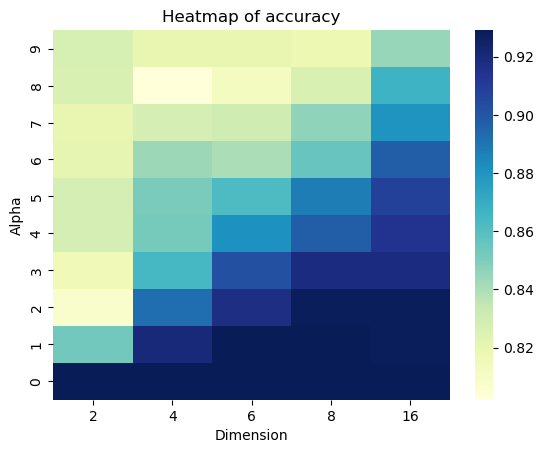

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = [
        [0.8275132275132275, 0.8201058201058201, 0.8201058201058201, 0.8179894179894179, 0.8444444444444446],
        [0.8264550264550266, 0.8021164021164022, 0.8116402116402117, 0.8264550264550264, 0.8666666666666667],
        [0.8201058201058201, 0.8285714285714287, 0.8306878306878307, 0.8465608465608465, 0.8804232804232804],
        [0.8211640211640212, 0.8433862433862435, 0.8402116402116403, 0.8560846560846561, 0.8973544973544975],
        [0.8285714285714285, 0.8507936507936507, 0.8624338624338624, 0.8878306878306879, 0.9079365079365079],
        [0.8285714285714285, 0.8518518518518519, 0.8814814814814814, 0.8973544973544973, 0.9142857142857144],
        [0.8158730158730159, 0.8645502645502646, 0.9026455026455028, 0.9185185185185185, 0.9185185185185186],
        [0.8074074074074074, 0.892063492063492, 0.9174603174603173, 0.9280423280423281, 0.9280423280423281],
        [0.852910052910053, 0.9206349206349206, 0.9291005291005291, 0.9291005291005291, 0.9280423280423281],
        [0.9291005291005291, 0.9291005291005291, 0.9291005291005291, 0.9291005291005291, 0.9291005291005291]
        ]

# Define custom x-values
x_values = ['2', '4', '6', '8', '16']
y_values = ['9', '8', '7', '6', '5', '4', '3', '2', '1', '0']

# Create heatmap with custom x-values
sns.heatmap(data, cmap='YlGnBu', xticklabels=x_values, yticklabels=y_values)

# Add labels and title
plt.xlabel('Dimension')
plt.ylabel('Alpha')
plt.title('Heatmap of accuracy')

# Show plot
plt.show()

In [137]:
conf_matrix = np.array([[np.mean(True_posetiv), np.mean(False_negativ)],
                        [np.mean(False_posetiv), np.mean(True_negativ)]])
conf_matrix_baseline = np.array([[np.mean(True_posetiv_baseline), np.mean(False_negativ_baseline)],
                        [np.mean(False_posetiv_baseline), np.mean(True_negativ_baseline)]])

In [138]:
np.array([[True_posetiv_baseline[1], False_negativ_baseline[1]],
        [False_posetiv_baseline[1], True_negativ_baseline[1]]])

array([[  4.,   0.],
       [  6., 170.]])

In [139]:
np.array([[True_posetiv[s], False_negativ[s]],
        [False_posetiv[s], True_negativ[s]]])

array([[  3.,  12.],
       [ 29., 145.]])

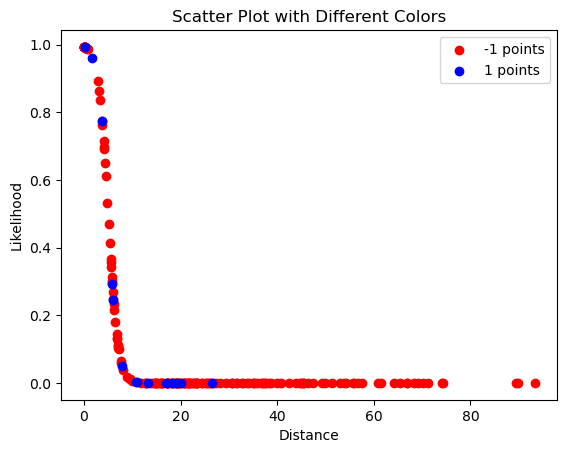

In [140]:
plt.scatter(distances[connections == -1], sigmoid_value[connections == -1], color='red', label='Not connected')
plt.scatter(distances[connections == 1], sigmoid_value[connections == 1], color='blue', label='Connected')
plt.xlabel('Distance')
#plt.xlim(4,5)
plt.ylabel('Likelihood')
plt.title('Scatter Plot with Different Colors')
plt.legend()
plt.show()


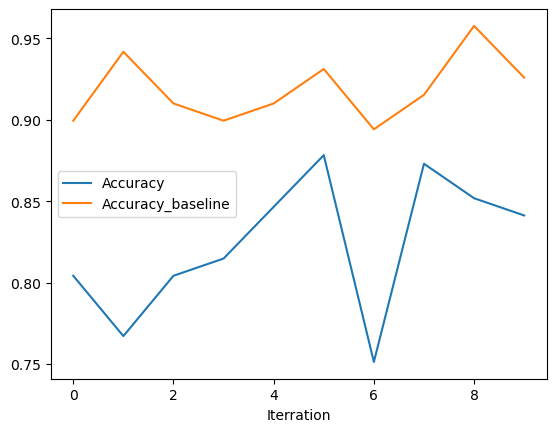

In [115]:
plt.plot(Accuracy,label='Accuracy')
plt.plot(Accuracy_baseline, label='Accuracy_baseline')
#plt.ylabel('MLL')
plt.xlabel('Iterration')
plt.legend()
plt.show()

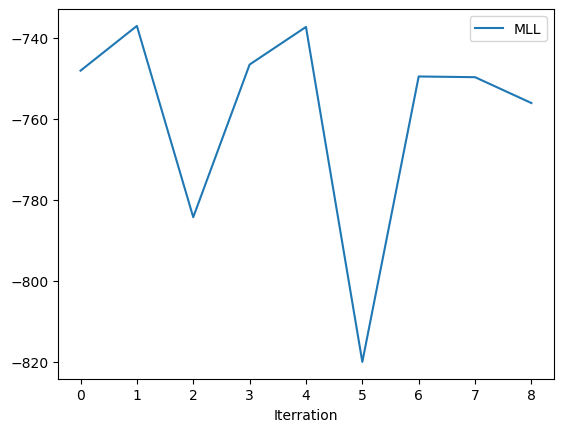

In [133]:
plt.plot(MLL_final,label='MLL')
#plt.plot(np.sqrt(grad_sum_final), label='Gradient sum')
#plt.ylabel('MLL')
plt.xlabel('Iterration')
plt.legend()
plt.show()

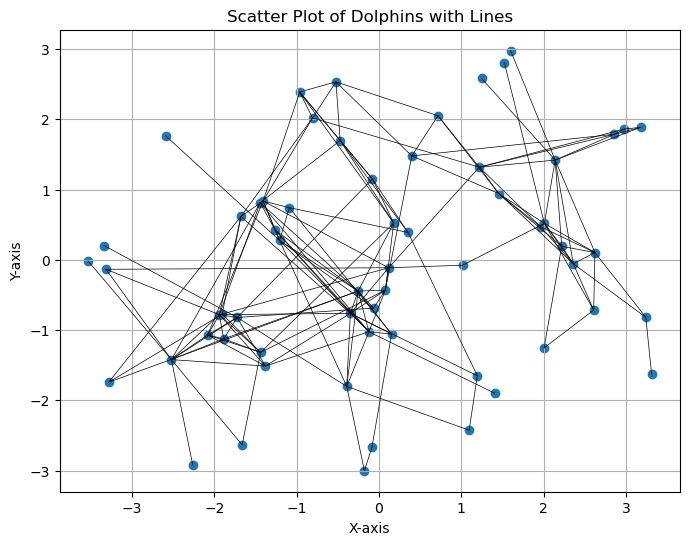

In [220]:
plt.figure(figsize=(8, 6))

for m in range(len(Y)): 
    if Y[m][0] == 1: # Check if there is a connection between Y[m][1] and Y[m][2]
        point1 = points_copy[Y[m][1]]
        point2 = points_copy[Y[m][2]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linewidth=0.5) # Ad a line between Y[m][1] and Y[m][2]

# extract the points and plot them
x = [point[0] for point in points_copy.values()]
y = [point[1] for point in points_copy.values()]
plt.scatter(x, y)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Dolphins with Lines')
plt.grid(True)
plt.show()